In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')

In [3]:
sim['SnapNumber_128/Groups/'].keys()

<KeysViewHDF5 ['GroupCM', 'GroupLen', 'GroupLenType', 'GroupMassType', 'GroupNsubs', 'GroupNumber', 'GroupSFR', 'Group_M_Crit200', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Mean200', 'Group_R_TopHat200', 'PartType0', 'PartType1', 'PartType4', 'PartType5', 'SnapNumber']>

In [4]:
def get_KrotOverK(ff):
    Soff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    cen = sim['SnapNumber_128/SubGroups/SubGroupPos'][ff]
    cenVel = sim['SnapNumber_128/SubGroups/SubGroupVel'][ff]

    Js = sim['SnapNumber_128/PartType4/SpecificAngularMomentum'][Soff[0]:Soff[1]]
    
    RotMass = sim['SnapNumber_128/SubGroups/PartType4/RotationMatrix'][ff]
    
    PosNow = sim['SnapNumber_128/PartType4/Coordinates'][Soff[0]:Soff[1]]
    VelNow = sim['SnapNumber_128/PartType4/Velocities'][Soff[0]:Soff[1]]

    posnow = np.array([PosNow[:,0]-cen[0], PosNow[:,1]-cen[1], PosNow[:,2]-cen[2]]).T
    velnow = np.array([VelNow[:,0]-cenVel[0], VelNow[:,1]-cenVel[1], VelNow[:,2]-cenVel[2]]).T
    masses = sim['SnapNumber_128/PartType4/Masses'][Soff[0]:Soff[1]]
    
    # I gonna modify this to use particles within one r_optical
    
#     ropt = sim['SnapNumber_128/SubGroups/OpticalRadius'][ff]
#     rpart = np.sqrt(posnow[:,0]**2+posnow[:,1]**2+posnow[:,2]**2)
#     i = np.where(rpart<ropt)
    
#     posnow = posnow[i]
#     velnow = velnow[i]
#     masses = masses[i]
#     Js = Js[i]
    
    posRot = np.dot(RotMass, posnow.T).T
    
    Jz = np.array([0., 0., 1.])
    
    Ji = 0.
    ip = []

    ic = 0
    for pr, jr, mm in zip(posRot, Js, masses):
        ddot = np.dot(jr, Jz)
        if ddot>0.:
            rr = np.sum(pr**2.)
            tp = ddot**2./(rr-np.dot(pr, Jz)**2.)
            Ji += mm*tp
            ip.append(ic)
        ic += 1
    
    ip = np.array(ip)
    
    vel = velnow[ip]
    v2 = vel[:,0]**2.+vel[:,1]**2.+vel[:,2]**2.

    Jt = masses[ip]*v2
    Kt = np.sum(Jt)
    
    return Ji/Kt

In [5]:
get_KrotOverK(4338), get_KrotOverK(4339), get_KrotOverK(4341), get_KrotOverK(4343)

(0.5462862343989598,
 0.5893988798645682,
 0.5158089397850296,
 0.42014226673442207)

In [6]:
get_KrotOverK(4470), get_KrotOverK(4471), get_KrotOverK(4473), get_KrotOverK(4474)

(0.62235559125455, 0.7058728647933169, 0.722205020931836, 0.7150030106675346)

In [6]:
import astropy.table as apt

In [7]:
T = apt.Table.read('tabla_merger_env_REF100_Mcut1e9_referee.txt', format='ascii')
T2 = apt.Table.read('local_density_REF100.txt', format='ascii')

In [13]:
galID = T['col1']
Ncell = T['col2']

galID2 = T2['col1']
Ncell2 = T2['col2']

galID2, Ncell2

(<Column name='col1' dtype='int64' length=7482>
      0
  17982
  37654
  48020
  56690
  64296
  70677
  77136
  80607
  83752
  87056
  89839
    ...
 587970
 589511
 591808
 592302
 607797
 612755
 613425
 630281
 635153
 638994
 665129
 667531,
 <Column name='col2' dtype='float64' length=7482>
 249.0
 364.0
 357.0
 285.0
 464.0
 253.0
 306.0
 204.0
 186.0
 257.0
 160.0
 274.0
   ...
  26.0
   5.0
   8.0
  14.0
  15.0
   5.0
   9.0
   5.0
  11.0
   9.0
  14.0
   2.0)

In [19]:
KoK, NcellDef = [], []

for g, n in zip(galID2, Ncell2):
    try:
        kk = get_KrotOverK(g)
        KoK.append(kk)
        NcellDef.append(n)
    except:
        pass
    
KoK = np.array(KoK)
NcellDef = np.array(NcellDef)

KoK.size, NcellDef.size

(1, 1)

In [20]:
KoK, NcellDef

(array([0.71447148]), array([249.]))

In [59]:
def getMass(ff):
    Soff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    masses = sim['SnapNumber_128/PartType4/Masses'][Soff[0]:Soff[1]]
    Mass = np.log10(np.sum(masses)*1e10)
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][ff]
    gMass = sim['SnapNumber_128/Groups/Group_M_Crit200'][group]
    GMass = np.log10(gMass*1e10)
    
    return Mass, GMass

In [71]:
getMass(4337)

(10.605669811328204, 11.97874485031806)

In [61]:
getMass(4339)

(8.395722114289644, 11.97874485031806)

In [72]:
galID

0
17982
48020
64296
77136
80607
89839
98021
105534
111730
113537


In [93]:
get_KrotOverK(4469)

0.5653500913431752

In [3]:
Header = sim['SnapNumber_128/Header']

In [4]:
Header.keys()

<KeysViewHDF5 ['BoxSize', 'HubbleParam', 'MassTable', 'Omega0', 'OmegaLambda', 'Redshift', 'Time']>

In [6]:
Header['BoxSize'][()], Header['HubbleParam'][()], Header['Omega0'][()], Header['OmegaLambda'][()]

(100000.0, 0.6711, 0.3175, 0.6825)

In [8]:
Header['BoxSize'].attrs['description_units']

'$h^{-1} ckpc$'

In [9]:
Header['MassTable'][()]

array([0.        , 0.00010843, 0.        , 0.        , 0.        ,
       0.        ])

In [10]:
np.log10(0.00010843*1e10)

6.035149457773463

In [40]:
poff0_1 = sim['SnapNumber_128/Groups/PartType0/Offsets'][4672].astype('int')
poff1_1 = sim['SnapNumber_128/Groups/PartType1/Offsets'][4672].astype('int')
poff4_1 = sim['SnapNumber_128/Groups/PartType4/Offsets'][4672].astype('int')

In [41]:
Mass0 = np.sum(sim['SnapNumber_128/PartType0/Masses'][poff0_1[0]:poff0_1[1]])
Mass4 = np.sum(sim['SnapNumber_128/PartType4/Masses'][poff4_1[0]:poff4_1[1]])
Mass1 = 0.00010843*(poff1_1[1]-poff1_1[0])

np.log10(Mass0+Mass4+Mass1)+10

11.805710042391436

In [10]:
np.log10(1.20171e+12), np.log10(1.90866e+12)

(12.07979967515817, 12.28072857204227)

In [35]:
Mass0 = np.sum(sim['SnapNumber_128/PartType0/Masses'][()])
Mass4 = np.sum(sim['SnapNumber_128/PartType4/Masses'][()])
Mass1 = 0.00010843*sim['SnapNumber_128/PartType1/ParticleIDs'][()].size

np.log10(Mass0+Mass4+Mass1)+10

13.022539899243949

In [14]:
sim['SnapNumber_128/PartType1/'].keys()

<KeysViewHDF5 ['Coordinates', 'GroupNumber', 'ParticleIDs', 'Potential', 'SubFindNumber', 'SubGroupNumber', 'Velocities']>

In [20]:
np.log10(1.20171e+12+1.90866e+12)

12.492812054428894

In [19]:
np.log10(np.mean(sim['SnapNumber_128/PartType4/Masses'][()]))+10, np.log10(np.std(sim['SnapNumber_128/PartType4/Masses'][()]))+10

(4.9374566078186035, 4.230424880981445)

In [18]:
np.log10(np.mean(sim['SnapNumber_128/PartType0/Masses'][()]))+10, np.log10(np.std(sim['SnapNumber_128/PartType0/Masses'][()]))+10

(5.28468132019043, 4.379548072814941)

In [12]:
sim['SnapNumber_128/PartType0/Masses'].attrs['description_units']

'$10^{10}  h^{-1} M_\\odot$'

In [13]:
sim['SnapNumber_128/PartType1/ParticleIDs'][()].size

8208528

In [14]:
8208528**(1/3)

201.72284966367138

In [15]:
201.72284966367138**3

8208527.9999999935

In [20]:
sim['SnapNumber_128/PartType4/Masses'][()].size

1207886

In [21]:
sim['SnapNumber_128/PartType0/Masses'][()].size

7931058

In [3]:
sim['SnapNumber_128/SubGroups/OpticalRadius'].attrs['description']

'Optical radii computed as the radius that encompass 83% of stellar and star-forming gas mass belonging to the SubGroup'

In [31]:
sim['SnapNumber_128/PartType4/Abundances'].attrs['description']

'Mass in individual elements: He, C, Mg, O, Fe, Si, H, N, Ne, S, Ca, Zi (in this order)'

In [5]:
sim['SnapNumber_128/PartType4/'].keys()

<KeysViewHDF5 ['Abundances', 'BindingEnergy', 'Circularity', 'Coordinates', 'GroupNumber', 'Masses', 'ParticleIDs', 'Potential', 'SpecificAngularMomentum', 'StellarFormationTime', 'SubFindNumber', 'SubGroupNumber', 'Velocities']>

In [46]:
np.isin?

In [27]:
# ok, lets select the times difference.

TimeEnd = []
TimeBegin = []

for i in range(30,128):
    TimeN = sim['SnapNumber_{}/Header/Time'.format(i+1)][()]
    TimeI = sim['SnapNumber_{}/PartType4/StellarFormationTime'.format(i)][()]
    pnow = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(i)][()]
    pnew = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(i+1)][()]
    
    Masses1 = sim['SnapNumber_{}/PartType4/Masses'.format(i)][()]
    Masses2 = sim['SnapNumber_{}/PartType4/Masses'.format(i+1)][()]
    
    iare = np.isin(pnow, pnew, assume_unique=True, invert=False)
    inow = np.isin(pnew, pnow, assume_unique=True, invert=False)
    
    pnow, Masses1 = pnow[iare], Masses1[iare]
    pnew, Masses2 = pnew[inow], Masses2[inow]
    
    TimeI = TimeI[iare]
    
    # ... and compare the masses
    is1 = np.argsort(pnow) # the target
    is2 = np.argsort(pnew)

    valMass2 = np.zeros(pnow.size)
    valMass2[is1] = Masses2[is2]
    
    theOnesThatDie = np.where(Masses1 > 1.2*valMass2)[0]
    if theOnesThatDie.size>0:
#         print(pnow.min(), pnow.max())
#         print(pnew.min(), pnew.max())
        print(theOnesThatDie.size, i, i+1)
        
    Timedie = list(TimeI[theOnesThatDie])
    Timenow = [TimeN]*len(Timedie)
    
    TimeEnd.extend(Timenow)
    TimeBegin.extend(Timedie)

492 30 31
674 31 32
966 32 33
1429 33 34
1622 34 35
1887 35 36
1896 36 37
2524 37 38
2326 38 39
3225 39 40
3879 40 41
4050 41 42
3820 42 43
2109 43 44
4262 44 45
1053 45 46
2962 46 47
3565 47 48
4681 48 49
5815 49 50
3986 50 51
4812 51 52
4441 52 53
7273 53 54
4674 54 55
6035 55 56
3747 56 57
4237 57 58
5879 58 59
2463 59 60
2446 60 61
2562 61 62
4872 62 63
3566 63 64
2235 64 65
2126 65 66
2136 66 67
2196 67 68
1908 68 69
1531 69 70
1683 70 71
1665 71 72
1605 72 73
2072 73 74
2364 74 75
1869 75 76
1762 76 77
1572 77 78
1296 78 79
1509 79 80
1692 80 81
1404 81 82
1553 82 83
1635 83 84
1733 84 85
1912 85 86
1623 86 87
1557 87 88
1880 88 89
1835 89 90
1394 90 91
1045 91 92
822 92 93
1622 93 94
1366 94 95
1020 95 96
877 96 97
911 97 98
793 98 99
824 99 100
822 100 101
700 101 102
1200 102 103
791 103 104
1032 104 105
885 105 106
1001 106 107
874 107 108
549 108 109
1079 109 110
581 110 111
884 111 112
663 112 113
827 113 114
1075 114 115
638 115 116
462 116 117
621 117 118
667 118 119
524 

In [21]:
sim['SnapNumber_128/Header/Time'].attrs['description']

'The scale factor a (=1/(1+z)) corresponding to the current snapshot'

In [22]:
zBegin = 1./np.array(TimeBegin) -1.
zEnd = 1./np.array(TimeEnd) -1.

zBegin[-1], zEnd[-1]

(0.001757741, 2.220446049250313e-16)

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
Tend = Cosmo.lookback_time(zEnd).value
TBegin = Cosmo.lookback_time(zBegin).value

TLife = TBegin - Tend

NameError: name 'zEnd' is not defined

Text(0, 0.5, 'Number')

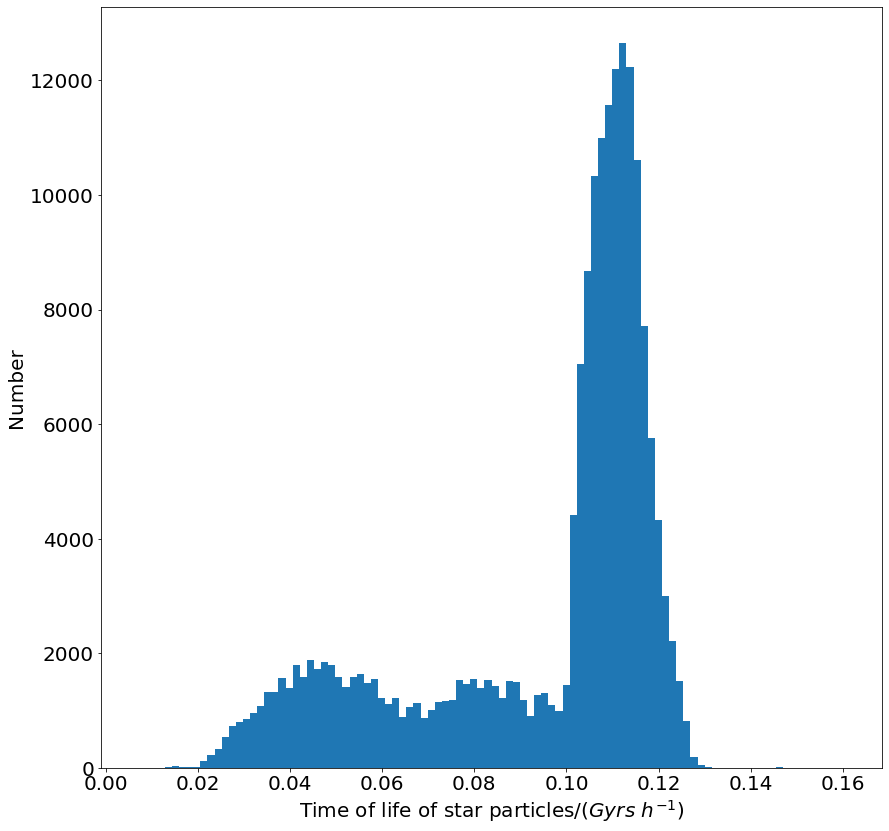

In [25]:
pl.figure(figsize=(14, 14))

pl.hist(TLife, bins=100)

pl.xlabel('Time of life of star particles$/(Gyrs\,\,h^{-1})$')
pl.ylabel('Number')

In [10]:
np.mean(TLife), np.median(TLife), np.std(TLife)

(0.09491648784993341, 0.10687983135284185, 0.02658044598236955)

In [6]:
# , ok, aprox 0.1 +/- 0.03 to take the mayority, even when the distribution is not, well, gaussian
# lets take a look at the difference between snapshots

Zsnap = []
for i in range(30, 129):
    zz = sim['SnapNumber_{}/Header/Redshift'.format(i)][()]
    Zsnap.append(zz)

In [7]:
Zsnap = np.array(Zsnap)

In [8]:
TimeSnap = Cosmo.lookback_time(Zsnap).value

In [9]:
dif = TimeSnap[:-1] - TimeSnap[1:]

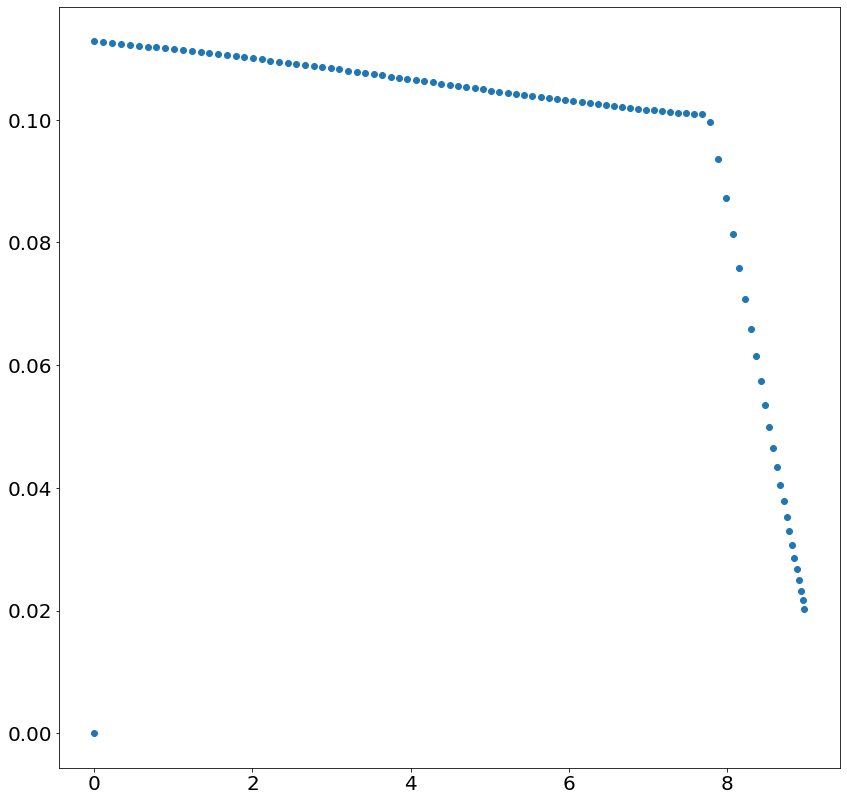

In [10]:
pl.figure(figsize=(14,14))

pl.plot(TimeSnap[1:], dif, marker='o', ls='')

In [11]:
sim['SnapNumber_128/PartType4/ParticleIDs'][0]

2149303829

In [12]:
# lets get the position of teh star particles.

Idstar = sim['SnapNumber_128/PartType4/SubFindNumber'][()]

idgal = np.array([4338, 4339, 4341, 4343, 4470, 4471, 4473, 4474])

stars = []
for idg in idgal:
    i = np.where(Idstar==idg)[0]
    stars.extend(list(i))
    
stars = np.array(stars)

In [13]:
stars.size

112122

In [30]:
# ok, now lets calculate times directly.
lifeSpectancy = []
Zs = []
Mass = []

MassMin = 8
MassMax = 40

eps0 = 1.35/(MassMin**(-1.35)-MassMax**(-1.35))

pb = progressbar.ProgressBar(max_value=stars.size)
c = 0

for s in stars:
    abund = sim['SnapNumber_128/PartType4/Abundances'][s]
    mass = sim['SnapNumber_128/PartType4/Masses'][s]
    
    Z = (np.sum(abund[1:6])+np.sum(abund[7:]))/mass
    if Z<10**(-5):
        Z = 10**(-5)
    if Z>10**(-2):
        Z = 10**(-2)
    
    rand = np.random.random()
    M = (-rand*1.35/eps0 + MassMin**(-1.35))**(-1/1.35)
    
    lZ = np.log10(Z)
    lM = np.log10(M)
    
    a0 = 10.13 + 0.07547*lZ - 0.008084*lZ**2
    a1 = -4.424 - 0.7939*lZ - 0.1187*lZ**2
    a2 = 1.262 + 0.3385*lZ + 0.05417*lZ**2
    
    lT = a0 + a1*lM + a2*lM**2
    lT = lT # in yrs
    lifeSpectancy.append(lT)
    Zs.append(Z)
    Mass.append(M)
    c += 1
    pb.update(c)
    
lifeSpectancy = np.array(lifeSpectancy)
Zs = np.array(Zs)
Mass = np.array(Mass)

100% (112122 of 112122) |################| Elapsed Time: 0:07:17 ETA:  00:00:00

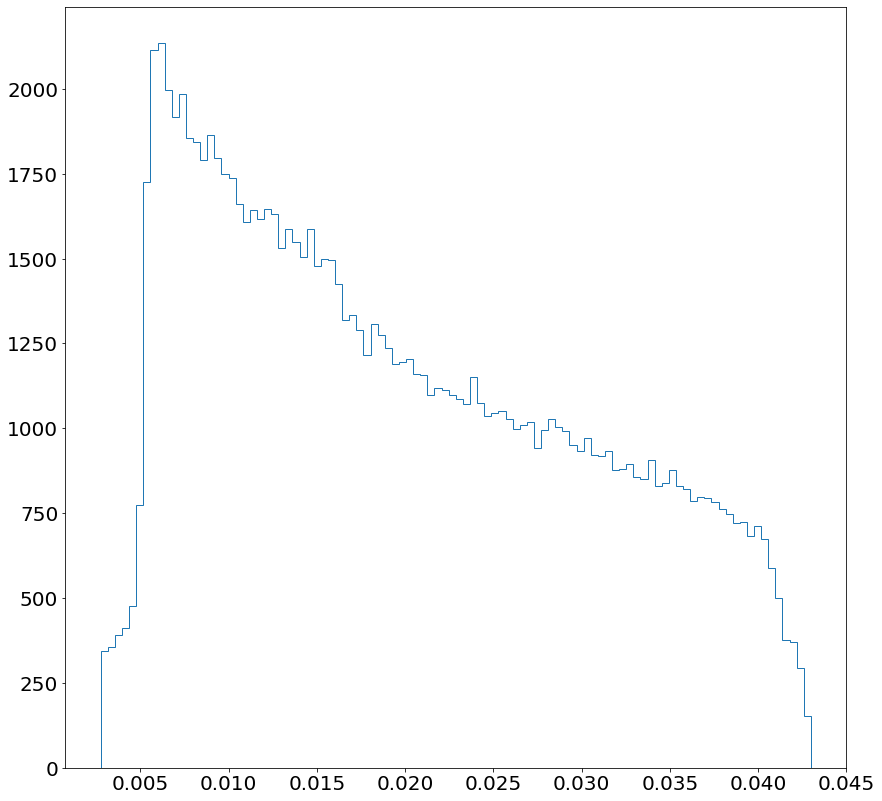

In [31]:
pl.figure(figsize=(14,14))

i = np.where(Mass>1)

h = pl.hist((10**lifeSpectancy[i])/1e9, bins=100, histtype='step')

In [32]:
np.median(10**(lifeSpectancy[i])/1e9), np.std(10**(lifeSpectancy[i])/1e9)

(0.018089395755499785, 0.010585338536808878)

In [27]:
Zs.min(), Zs.max()

(1e-05, 0.01)

In [28]:
Mass.min(), Mass.max()

(1.0000086943939912, 39.99652993659734)

(array([44373., 26782., 16437.,  9986.,  5912.,  3707.,  2236.,  1371.,
          828.,   490.]),
 array([3.77591092e-06, 1.60205630e-01, 3.20407484e-01, 4.80609337e-01,
        6.40811191e-01, 8.01013045e-01, 9.61214899e-01, 1.12141675e+00,
        1.28161861e+00, 1.44182046e+00, 1.60202231e+00]),
 <a list of 10 Patch objects>)

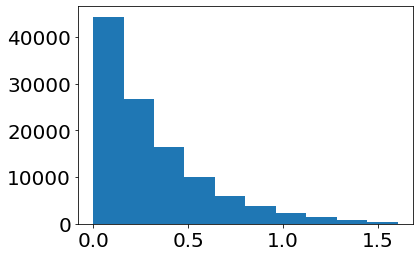

In [29]:
pl.hist(np.log10(Mass))